In [ ]:
from pathlib import Path
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

In [2]:
def parse_file_data(file_path):
    rows_number = None
    submitted_index = None
    try:
        with open(file_path, 'r') as f:
            # --- Read First 100 Chars ---
            f.seek(0)
            first_100_chars = f.read(100)
            rows_pattern = re.compile(r'"rows": \[\s*(\d+)\s*\]')
            match = rows_pattern.search(first_100_chars)

            if match:
                rows_number = int(match.group(1))
            else:
                print("❌ 'rows' pattern not found in the first 100 characters.", file_path)

            # --- Read Last 100 Chars ---
            # Move the file pointer to the end of the file
            f.seek(0, os.SEEK_END)
            # Move back 100 characters from the end
            file_size = f.tell()
            f.seek(max(0, file_size - 100))
            last_100_chars = f.read()

            # Regex to find the number within '"submitted_row_indices": [N]'
            submitted_pattern = re.compile(r'"submitted_row_indices": \[\s*(\d+)\s*\]')
            match = submitted_pattern.search(last_100_chars)
            if match:
                submitted_index = int(match.group(1))

    except IOError as e:
        print(f"An error occurred while reading the file: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

    return rows_number, submitted_index


def get_row_accuracy(paths):
    successful_attemps = defaultdict(lambda: 0)
    tot_attempts = defaultdict(lambda: 0)

    def _check_success_for_rollout(path):
        rows_number, submitted_index = parse_file_data(path)
        success = submitted_index == rows_number - 2
        tot_attempts[rows_number] += 1
        if success:
            successful_attemps[rows_number] += 1

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(_check_success_for_rollout, path): path for path in paths}
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            path = futures[future]
            try:
                _ = future.result()
                print(f"Progress: {(i+1) * 100 / len(paths):.02f}%", end="\r")
            except Exception as e:
                print(f"❌ {path} failed: {e}")

    return {row: successful_attemps[row] / tot_attempts[row] for row in tot_attempts.keys()}

In [3]:
ITERATION_1_FILES = \
    list(Path("../../data/rollouts/20251116_161543/").glob("*.json")) + \
    list(Path("../../data/rollouts/20251118_205148/").glob("*.json")) + \
    list(Path("../../data/rollouts/20251119_124456/").glob("*.json")) + \
    list(Path("../../data/rollouts/20251119_223016/").glob("*.json"))

ITERATION_2_FILES = \
    list(Path("../../data/rollouts/20251128_132027/").glob("*.json"))

ITERATION_3_FILES = \
    list(Path("../../data/rollouts/20251129_091728/").glob("*.json")) + \
    list(Path("../../data/rollouts/20251129_101412/").glob("*.json"))

ITERATION_4_FILES = \
    list(Path("../../data/rollouts/20251213_130628/").glob("*.json"))

ITERATION_4_step15000_FILES = \
    list(Path("../../data/rollouts/20251214_191056/").glob("*.json"))

In [ ]:
ITERATION_1_ACCURACY = get_row_accuracy(ITERATION_1_FILES)

In [ ]:
ITERATION_2_ACCURACY = get_row_accuracy(ITERATION_2_FILES)

In [4]:
with open("it3_error_rates.pkl", "rb") as f:
    it3_error_rates = pickle.load(f)
    ITERATION_3_ACCURACY = {k: 1-v for k, v in it3_error_rates.items()}

In [5]:
ITERATION_4_ACCURACY = get_row_accuracy(ITERATION_4_FILES)

In [6]:
ITERATION_4_step15000_ACCURACY = get_row_accuracy(ITERATION_4_step15000_FILES)

In [8]:
#print(f"Iteration 1 accuracy: {sum(ITERATION_1_ACCURACY.values()) / len(ITERATION_1_ACCURACY)}")
#print(f"Iteration 2 accuracy: {sum(ITERATION_2_ACCURACY.values()) / len(ITERATION_2_ACCURACY)}")
print(f"Iteration 3 accuracy: {sum(ITERATION_3_ACCURACY.values()) / len(ITERATION_3_ACCURACY)}")
print(f"Iteration 4 (step_2000) accuracy: {sum(ITERATION_4_ACCURACY.values()) / len(ITERATION_4_ACCURACY)}")
print(f"Iteration 4 (step_15000) accuracy: {sum(ITERATION_4_step15000_ACCURACY.values()) / len(ITERATION_4_step15000_ACCURACY)}")

Iteration 3 accuracy: 0.51354821167605
Iteration 4 (step_2000) accuracy: 0.5798773057810491
Iteration 4 (step_15000) accuracy: 0.5533561493715584


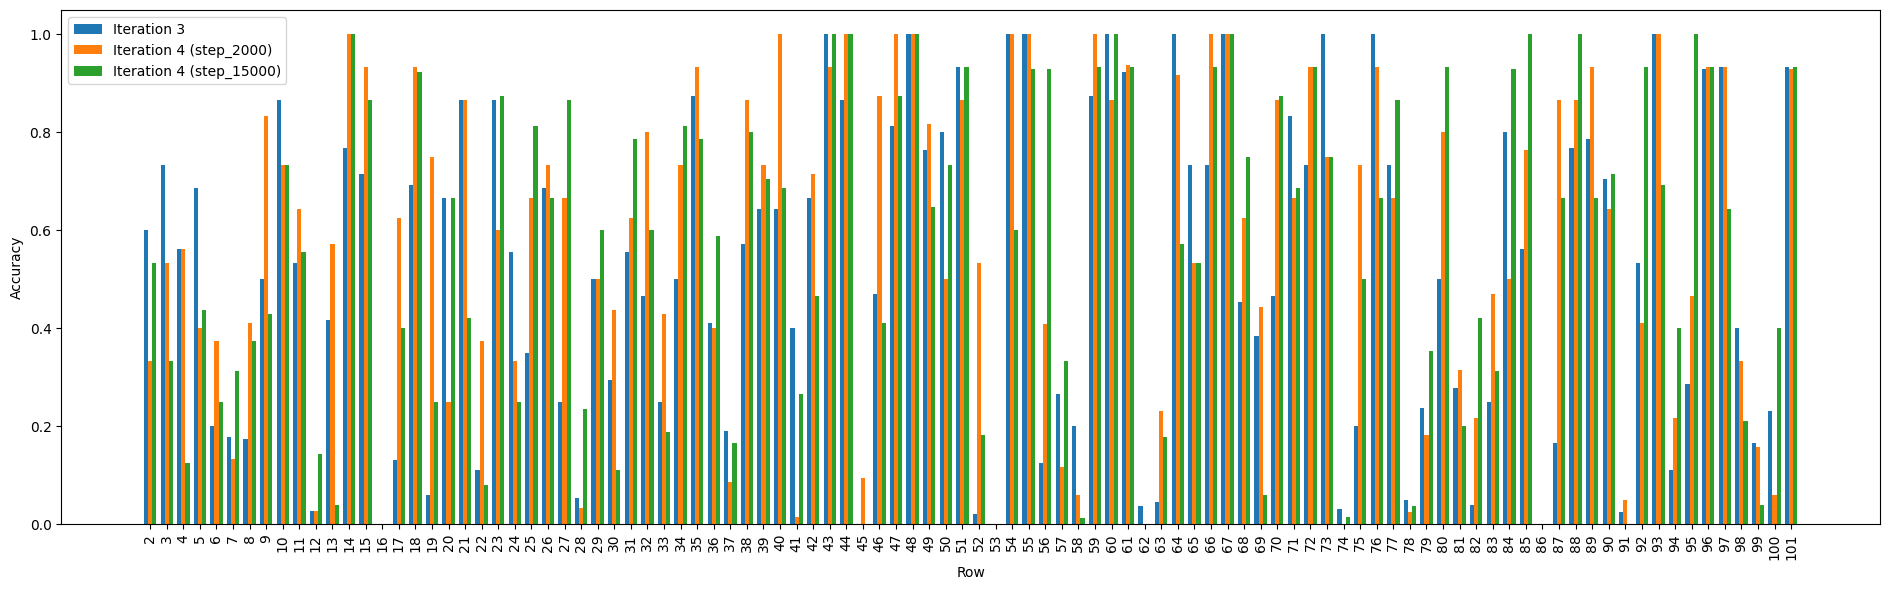

In [9]:
x_all = list(range(2, 102)) #sorted(set(ITERATION_1_ACCURACY.keys()) | set(ITERATION_2_ACCURACY.keys()) | set(ITERATION_3_ACCURACY.keys()))
#y1 = [ITERATION_1_ACCURACY.get(x, 0) for x in x_all]
#y2 = [ITERATION_2_ACCURACY.get(x, 0) for x in x_all]
y3 = [ITERATION_3_ACCURACY.get(x, 0) for x in x_all]
y4 = [ITERATION_4_ACCURACY.get(x, 0) for x in x_all]
y5 = [ITERATION_4_step15000_ACCURACY.get(x, 0) for x in x_all]


bar_width = 0.25
import numpy as np
x_inds = np.arange(len(x_all))

plt.figure(figsize=(19,6))
plt.bar(x_inds - bar_width, y3, width=bar_width, label='Iteration 3')
plt.bar(x_inds, y4, width=bar_width, label='Iteration 4 (step_2000)')
plt.bar(x_inds + bar_width, y5, width=bar_width, label='Iteration 4 (step_15000)')
plt.xticks(x_inds, x_all, rotation=90)
plt.xlabel("Row")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
d = {2: 0.6,
 3: 0.7333333333333333,
 4: 0.5625,
 5: 0.6875,
 6: 0.2,
 7: 0.17857142857142858,
 8: 0.17391304347826086,
 10: 0.8666666666666667,
 11: 0.5333333333333333,
 9: 0.5,
 12: 0.02631578947368421,
 13: 0.4166666666666667,
 14: 0.7692307692307693,
 15: 0.7142857142857143,
 16: 0.0,
 17: 0.13043478260869565,
 18: 0.6923076923076923,
 19: 0.058823529411764705,
 20: 0.6666666666666666,
 21: 0.8666666666666667,
 22: 0.1111111111111111,
 23: 0.8666666666666667,
 24: 0.5555555555555556,
 25: 0.35,
 26: 0.6875,
 27: 0.25,
 28: 0.05263157894736842,
 29: 0.5,
 30: 0.29411764705882354,
 31: 0.5555555555555556,
 32: 0.4666666666666667,
 33: 0.25,
 34: 0.5,
 35: 0.875,
 36: 0.4117647058823529,
 37: 0.19047619047619047,
 38: 0.5714285714285714,
 39: 0.6428571428571429,
 40: 0.6428571428571429,
 41: 0.4,
 42: 0.6666666666666666,
 43: 1.0,
 44: 0.8666666666666667,
 45: 0.0,
 46: 0.47058823529411764,
 47: 0.8125,
 48: 1.0,
 49: 0.7647058823529411,
 50: 0.8,
 51: 0.9333333333333333,
 52: 0.020833333333333332,
 53: 0.0,
 54: 1.0,
 55: 1.0,
 56: 0.125,
 57: 0.26666666666666666,
 58: 0.2,
 59: 0.875,
 60: 1.0,
 61: 0.9230769230769231,
 62: 0.037037037037037035,
 63: 0.045454545454545456,
 64: 1.0,
 65: 0.7333333333333333,
 66: 0.7333333333333333,
 67: 1.0,
 68: 0.45454545454545453,
 69: 0.38461538461538464,
 70: 0.4666666666666667,
 71: 0.8333333333333334,
 72: 0.7333333333333333,
 73: 1.0,
 74: 0.030303030303030304,
 75: 0.2,
 76: 1.0,
 77: 0.7333333333333333,
 78: 0.05,
 79: 0.23809523809523808,
 80: 0.5,
 81: 0.2777777777777778,
 82: 0.04,
 83: 0.25,
 84: 0.8,
 85: 0.5625,
 86: 0.0,
 87: 0.16666666666666666,
 88: 0.7692307692307693,
 89: 0.7857142857142857,
 90: 0.7058823529411765,
 91: 0.024390243902439025,
 92: 0.5333333333333333,
 93: 1.0,
 94: 0.1111111111111111,
 95: 0.2857142857142857,
 96: 0.9285714285714286,
 97: 0.9333333333333333,
 98: 0.4,
 99: 0.16666666666666666,
 100: 0.23076923076923078,
 101: 0.9333333333333333}

import pickle
error_rates = {task: 1-a for task, a in d.items()}
with open("it3_error_rates.pkl", "wb") as f:
    pickle.dump(error_rates, f)

In [7]:
from scipy.special import softmax
import matplotlib.pyplot as plt

<BarContainer object of 100 artists>

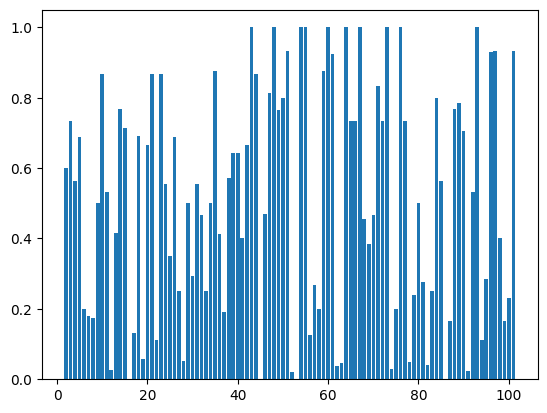

In [14]:
plt.bar(d.keys(), d.values())

<BarContainer object of 100 artists>

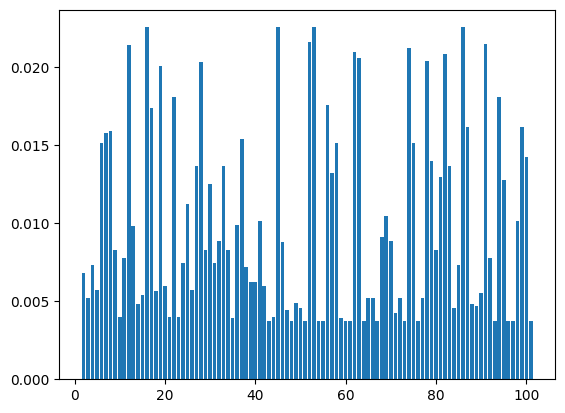

In [ ]:
dist = softmax([max(error_rates[task], 0.1) / 0.5 for task in error_rates.keys()])

plt.bar(d.keys(), dist)